In [1]:
import sys
import numpy as np

from PySDM.backends import CPU, GPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics import Breakup
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius, KMoments
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

In [5]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import ConstantK, Golovin
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict

@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**8
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 123
        self._steps = [0, 10, 20]
        self.kernel = Golovin(b=1500e3 / si.second)
        self.coal_eff = ConstEc(0.5)
        self.fragmentation = SLAMS()
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

[27.26100979] [99.997952] [9.99979520e+07 1.19039437e-05 2.81166547e-18]
[29.8620061] [29.630424] [2.96304240e+07 1.19039475e-05 6.27245745e-15]
[779.28603186] [0.003] [3.00000000e+03 1.19039418e-05 2.05117419e-13]


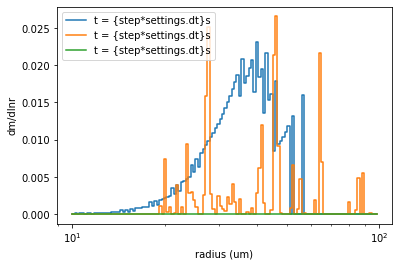

In [6]:
settings = Settings()
backend = GPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), KMoments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    #print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get(), core.products['M0-Mk'].get(3))
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()

[27.26101585] [99.997952] [9.99979520e+07 1.19039420e-05 2.81166553e-18]
[16.15334121] [232.635733] [2.32635733e+08 1.19039420e-05 4.08338395e-16]
[122.09854341] [0.638689] [6.38689000e+05 1.19039420e-05 7.12712473e-15]


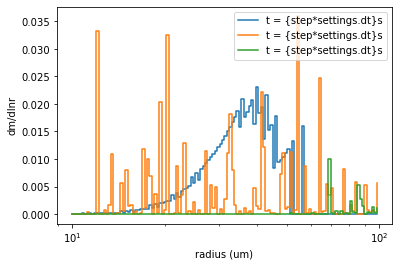

In [7]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), KMoments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    #print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get(), core.products['M0-Mk'].get(3))
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()